In [287]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr                      
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from datetime import date, time, datetime 
import pandas as pd 
import netCDF4 as net
from netCDF4 import num2date
import scipy.io
from scipy.io import loadmat
from scipy import interpolate

In [288]:
dataset = scipy.io.loadmat('Routine_v020721.mat')
alongtrack = xr.open_dataset('/Users/emmagurcan/Documents/JPL 2021/along-track data/Sentinel3A_NRT_2019_2020.nc')

In [289]:
print(dataset.keys())
print(np.min(dataset['lon']))
x_min = np.min(dataset['lon'])
x_max = np.max(dataset['lon'])
y_min = np.min(dataset['lat'])
y_max = np.max(dataset['lat'])
lon = dataset['lon']
lat = dataset['lat']

dict_keys(['__header__', '__version__', '__globals__', 't', 'lon', 'lat', 'adt2', 'vg2', 'ug2'])
-131.7407407407407


In [290]:
adt = dataset['adt2']
times = dataset['t']  
time_mean = np.mean(adt, axis = 2)

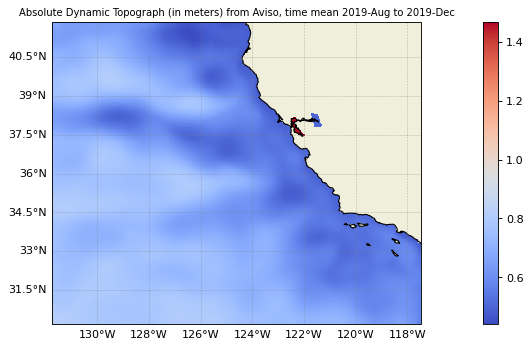

In [332]:
fig = plt.figure(figsize = (20, 5), dpi = 80)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title('Absolute Dynamic Topograph (in meters) from Aviso, time mean 2019-Aug to 2019-Dec', fontsize = 9)
ax.set_extent([x_min, x_max, y_min, y_max], crs = ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
gl.top_labels = False     # don't want to plot labels on top side
gl.right_labels = False 
f = ax.pcolormesh(lon, lat, time_mean, cmap = 'coolwarm')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE) 

vmin = 0.4
vmax = 0.9
levels = 5
level_boundaries = np.linspace(vmin, vmax, levels + 1)
plt.colorbar(f)

#plt.clim(0.4, 0.9)

plt.show()

In [330]:
# Function to convert datenum to datetime
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=int(matlab_datenum%1)) - dt.timedelta(days = 366)
    return day + dayfrac

In [293]:
# Function to find index of specific date
def time_idx(year, month, day, times):
    idx = -1
    for time in times:
        idx += 1
        if matlab2datetime(time) == datetime(year, month, day):
            return idx

In [294]:
print(matlab2datetime(times[0]))

2019-08-01 00:00:00


In [295]:
year = 2019
month = 8
day = 1
idx = time_idx(year, month, day, times)
print(idx)

0


In [296]:
def plot_model_at_date(dataset, year, month, day):
    # Determine data to plot
    adt = dataset['adt2']
    times = dataset['t'] 
    idx = time_idx(year, month, day, times)
    plot_data = adt[:, :, idx]
    
    # Determine parameters
    lon = dataset['lon']
    lat = dataset['lat']
    x_min = np.min(lon)
    x_max = np.max(lon)
    y_min = np.min(lat)
    y_max = np.max(lat)
    
    # Create figure
    fig = plt.figure(figsize = (20, 5), dpi = 80)
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax.set_extent([x_min, x_max, y_min, y_max], crs = ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
    gl.top_labels = False     # don't want to plot labels on top side
    gl.right_labels = False 
    f = ax.pcolormesh(lon, lat, plot_data, cmap = 'coolwarm')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE) 
    
    # Colorbar
    vmin = 0.4
    vmax = 0.9
    levels = 5
    level_boundaries = np.linspace(vmin, vmax, levels + 1)
    fig.colorbar(f,  boundaries=level_boundaries)
    
    # Title
    title = "Absolute Dynamic Topograph (in meters) from Model on {year}-{month}-{day}"
    ax.set_title(title.format(year = int(year), month = int(month), day = int(day)))
    
    plt.show()

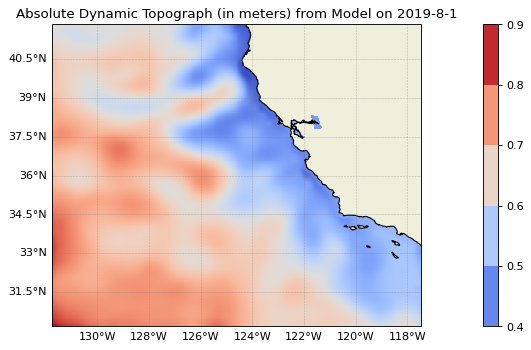

In [297]:
plot_model_at_date(dataset, 2019, 8, 1)

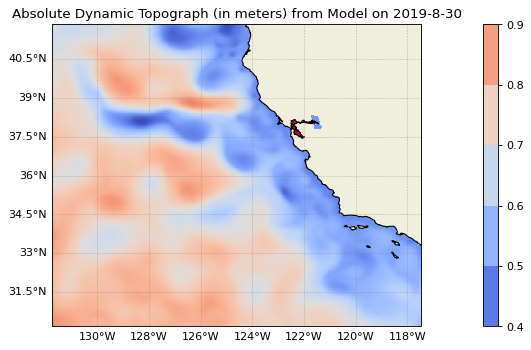

In [298]:
plot_model_at_date(dataset, 2019, 8, 30)

In [277]:
def plot_alongtrack_data(dataset, data, title):
    #determine the long and lat
    long = dataset['longitude']
    lat = dataset['latitude']
    
    # determine coordinates
    attributes = dataset.attrs
    x_min = attributes['longitude_min']
    x_max = attributes['longitude_max']
    y_min = attributes['latitude_min']
    y_max = attributes['latitude_max']
    
    # set figure axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # define the map projection
    ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False 
    
    # plot data
    plt.scatter(long, lat, c=data, s=5, cmap = 'coolwarm')
    
    # coastlines
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    #colorbar
    plt.colorbar(shrink = 0.5)
    
    # set title
    plt.title(title)
    
    plt.show()

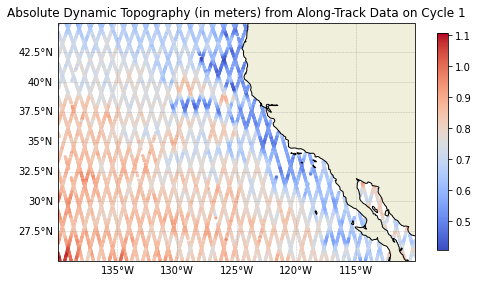

In [280]:
#ground tracks plot
alongtrack_adt = alongtrack['adt']
alongtrack_lon = alongtrack['longitude']
alongtrack_lat = alongtrack['latitude']
adt_day_1 = adt_data[1, :, :]
title = 'Absolute Dynamic Topography (in meters) from Along-Track Data on Cycle 1'

plot_alongtrack_data(alongtrack, adt_day_1, title)

In [ ]:
# INTERPOLATION

In [306]:
# Extract Variables
model = scipy.io.loadmat('Routine_v020721.mat')

alongtrack_adt = alongtrack['adt']
alongtrack_lon = alongtrack['longitude']
alongtrack_lat = alongtrack['latitude']
alongtrack_time = alongtrack['time']

model_lon = model['lon']
model_lat = model['lat']
model_adt = model['adt2']
model_time = model['t']

z = alongtrack_adt[1, :, :]
x = alongtrack_lon
y = alongtrack_lat
t = alongtrack_time

x_new = alongtrack_lon
y_new = alongtrack_lat
t_new = model_adt[:, : 0]
new_model = interpolate.interpolate(z, x, t, y, x_new, y_new, t_new)

TypeError: 'module' object is not callable

In [307]:
def determine_new_coord(alongtrack, model):
    new = []
    for point1 in model:
        for point2 in alongtrack:
            if point1 == point2:
                new.append(point1)
    return new

new_lon = determine_new_coord(alongtrack_lon, model_lon)

<ipython-input-307-086f24328107>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if point1 == point2:


ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: 'c' argument has 151312 elements, which is inconsistent with 'x' and 'y' with size 24624.

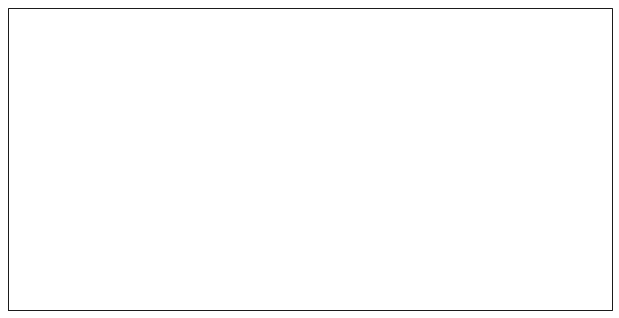

In [303]:
d = model_adt[:, :, 0]
fig = plt.figure(figsize = (20, 5), dpi = 80)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
plt.scatter(alongtrack_lon, alongtrack_lat, c = d, s = 5, cmap = 'coolwarm')